In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.decomposition import PCA

from keras.models import Model 
from keras.layers import Input, Flatten
from keras.applications.vgg16 import VGG16

In [17]:
def vgg_model(input_dim):
    input_layer = Input(shape=input_dim)
    vgg = VGG16(include_top=False, input_tensor=input_layer)
    o = Flatten()(vgg.output)
    
    return Model(inputs=input_layer, outputs=o)
    

In [18]:
vgg_model = vgg_model((128, 128, 3))

In [35]:
with h5py.File("../data/images.h5", "r") as fo:
    train_targets = np.array(fo["train_targets"])
    test_targets = np.array(fo["test_targets"])
    original_train = np.array(fo["train_features"])
    original_test = np.array(fo["test_features"])

<IPython.core.display.Javascript object>


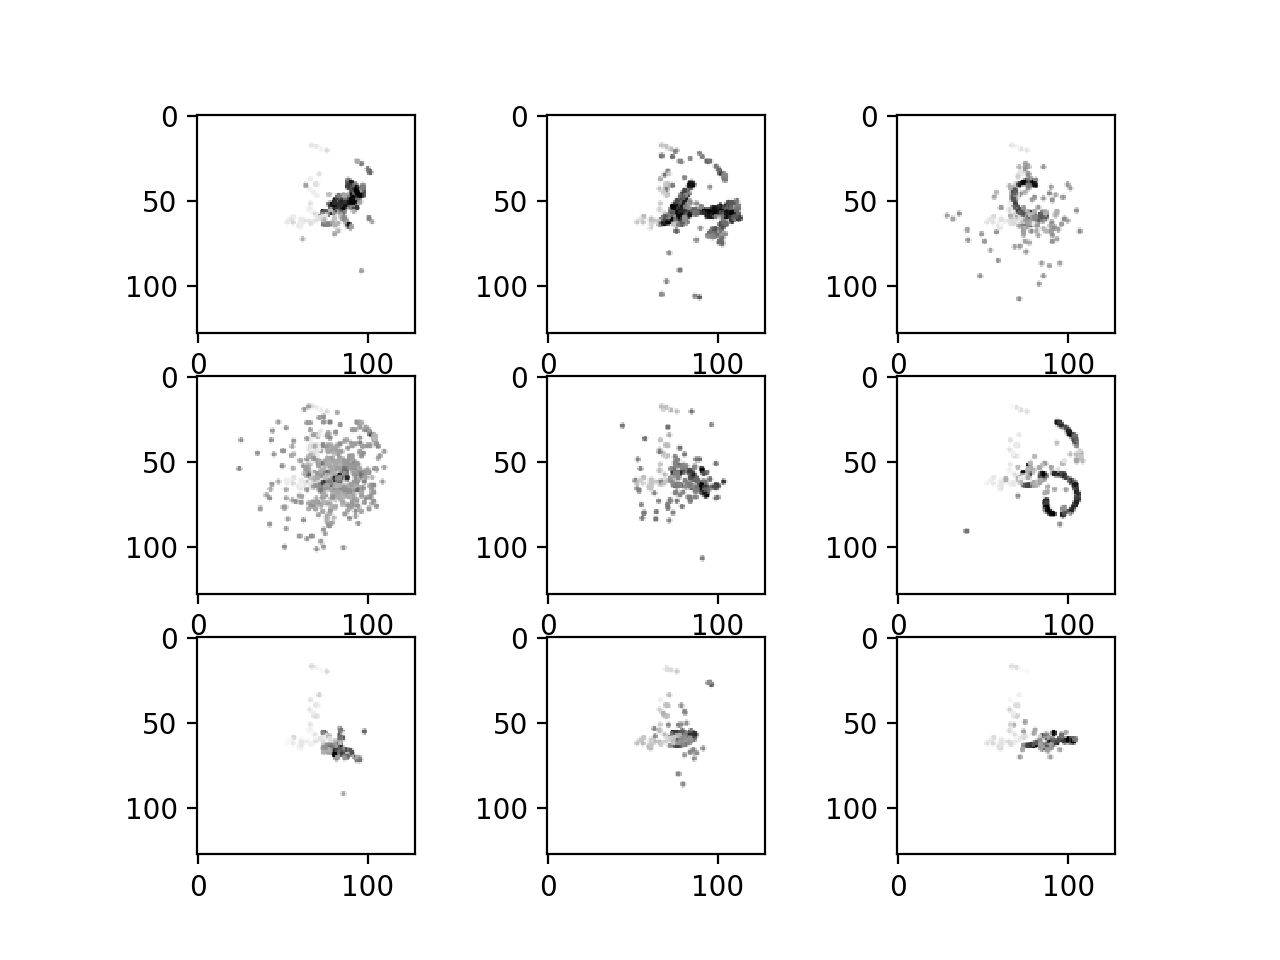

In [95]:
fig, ax = plt.subplots(nrows=3, ncols=3)
n_tot = 0

for row in ax:
    for a in row:      
        a.imshow(original_test[n_tot])
        n_tot += 1

plt.show()

In [24]:
vgg_repr = vgg_model.predict(original_train)

In [75]:
pca = PCA(50,)
pca.fit(vgg_repr)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


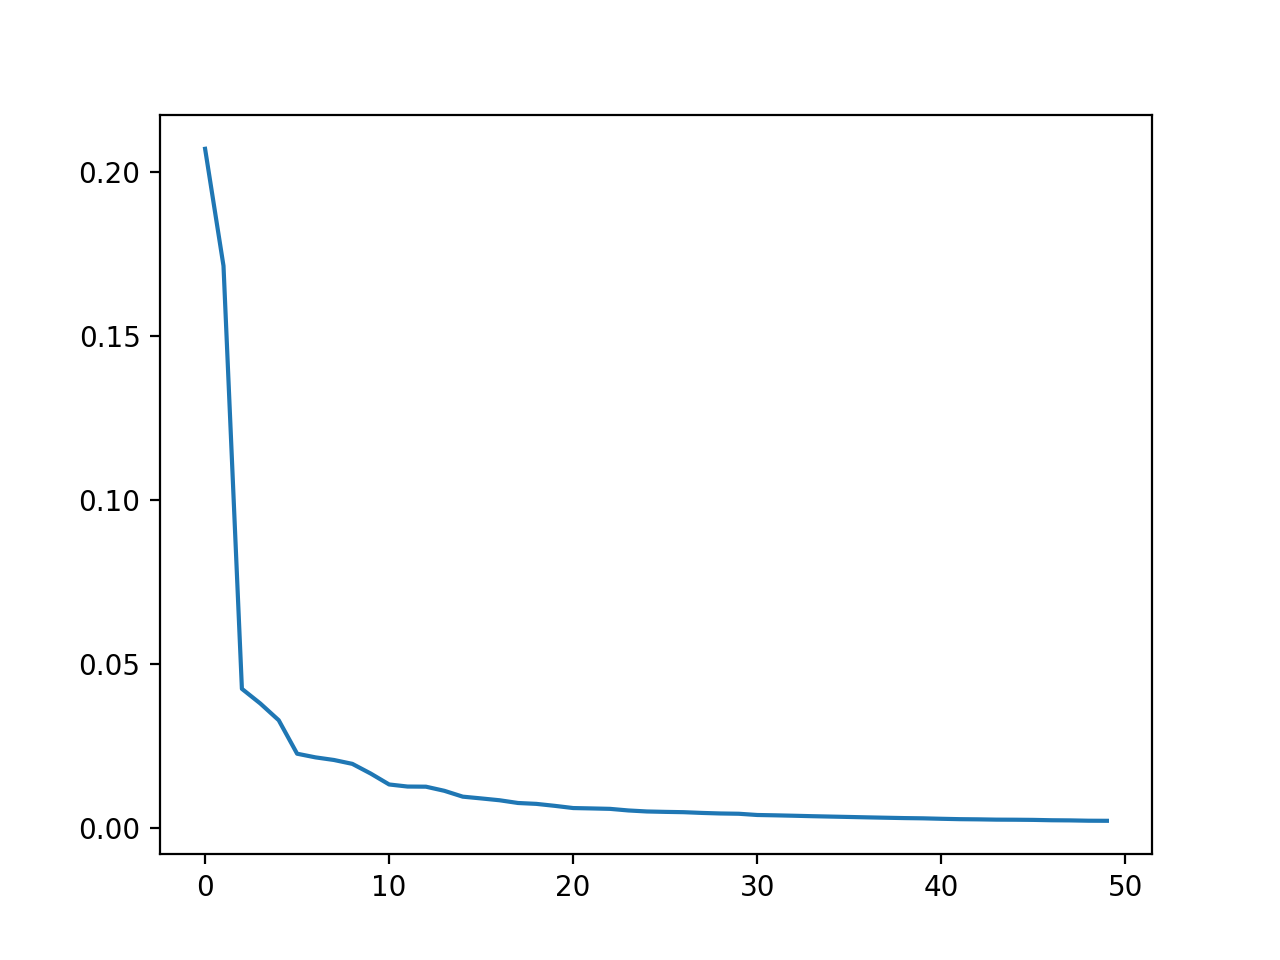

In [77]:
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_)

In [79]:
pca_vgg_train = pca.transform(vgg_repr)
pca_vgg_test = pca.transform(vgg_model.predict(original_test))

In [96]:
from sklearn.cluster import MiniBatchKMeans

cluster_model = MiniBatchKMeans(
    n_clusters=3,
    batch_size=150,
    n_init=100,
    )
cluster_model.fit(pca_vgg_train)
train_pred = cluster_model.predict(pca_vgg_train)
test_pred = cluster_model.predict(pca_vgg_test)

In [52]:
def latent_distance(x, y, weight_func=lambda x: x):
    """
    x and y should  be T by L matrices 
    this function measures  euclidian distance along T
    and reduces to a float along L 
    """
    
    sub = x - y 
    sub = weight_func(sub)
    
    tmp = np.power(sub, 2)
    tmp = np.sum(tmp, axis=1)
    tmp = np.sqrt(tmp,)
    
    return np.sum(tmp)

def euclidian(x, y):
    return(np.sqrt(np.sum(np.power(x-y, 2))))

n_events = pca_vgg_train.shape[0]
train_dist_matrix = np.zeros((n_events, n_events))

n_test = pca_vgg_test.shape[0]
test_dist_matrix = np.zeros((n_test, n_test))

T = np.expand_dims(np.arange(pca_vgg_train.shape[0],), -1)
linear_weight = lambda x: x/(1 + T )

for i in range(n_events):
    for j in range(n_events):
        #dist_matrix[i, j] = latent_distance(original_latent[:, i, :], original_latent[:, j, :], weight_func=linear_weight)
        train_dist_matrix[i, j] = euclidian(pca_vgg_train[i, :], pca_vgg_train[j, :])
        

for i in range(n_test):
    for j in range(n_test):
        #dist_matrix[i, j] = latent_distance(original_latent[:, i, :], original_latent[:, j, :], weight_func=linear_weight)
        test_dist_matrix[i, j] = euclidian(pca_vgg_test[i, :], pca_vgg_test[j, :])
        

<IPython.core.display.Javascript object>


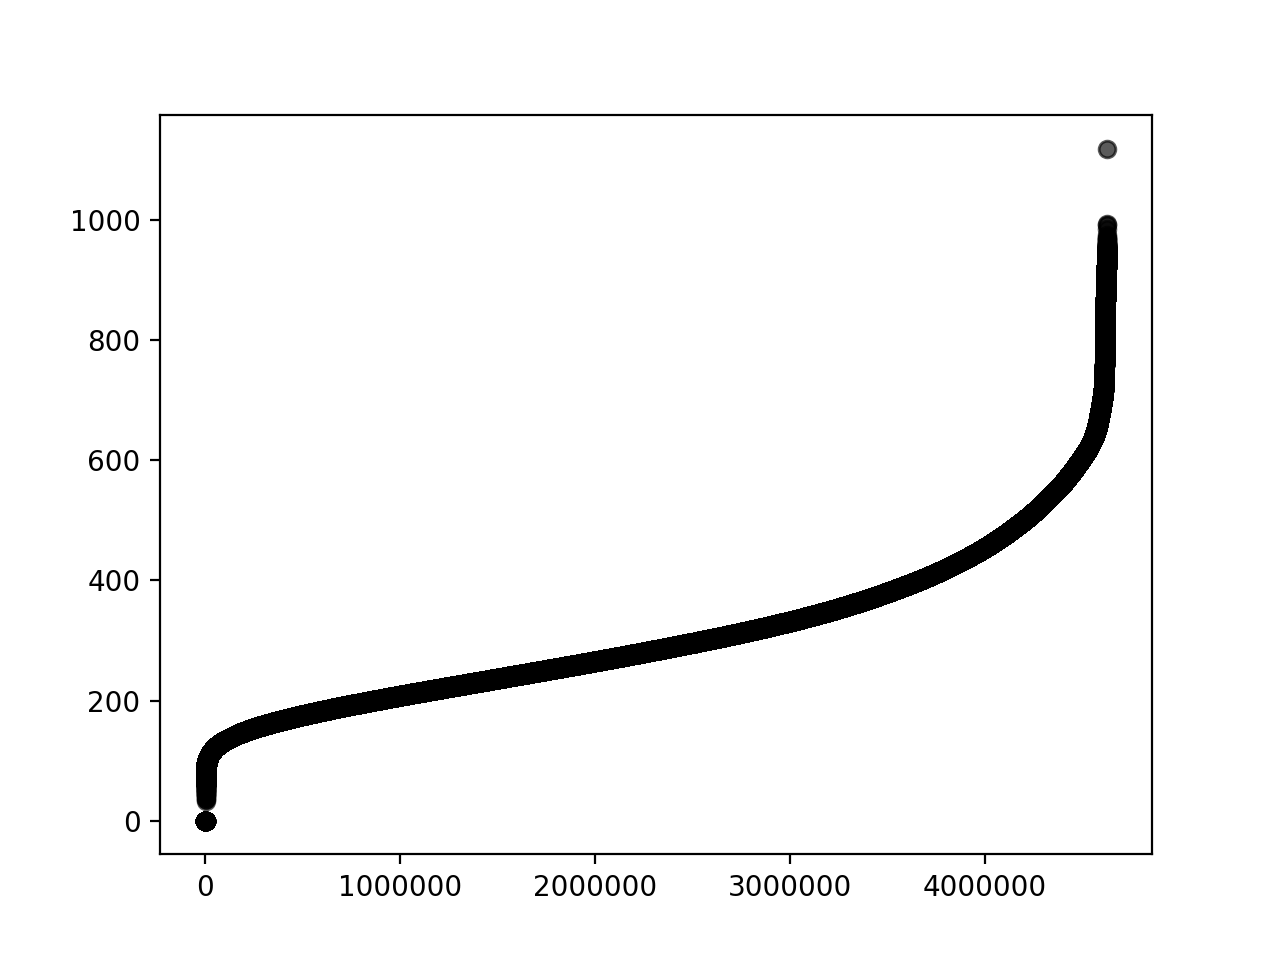

In [53]:
%matplotlib notebook

flat_dist = train_dist_matrix.flatten()
flat_dist.sort()
plt.plot(flat_dist, "ko", alpha=0.4)


In [60]:
from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(
                eps=200,
                metric="precomputed",
                min_samples=8
            )

train_pred = cluster_model.fit_predict(train_dist_matrix)
#test_pred = cluster_model.transform(test_dist_matrix)

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 85 272 190]
 [215   0  57]
 [703   0 629]]


<IPython.core.display.Javascript object>


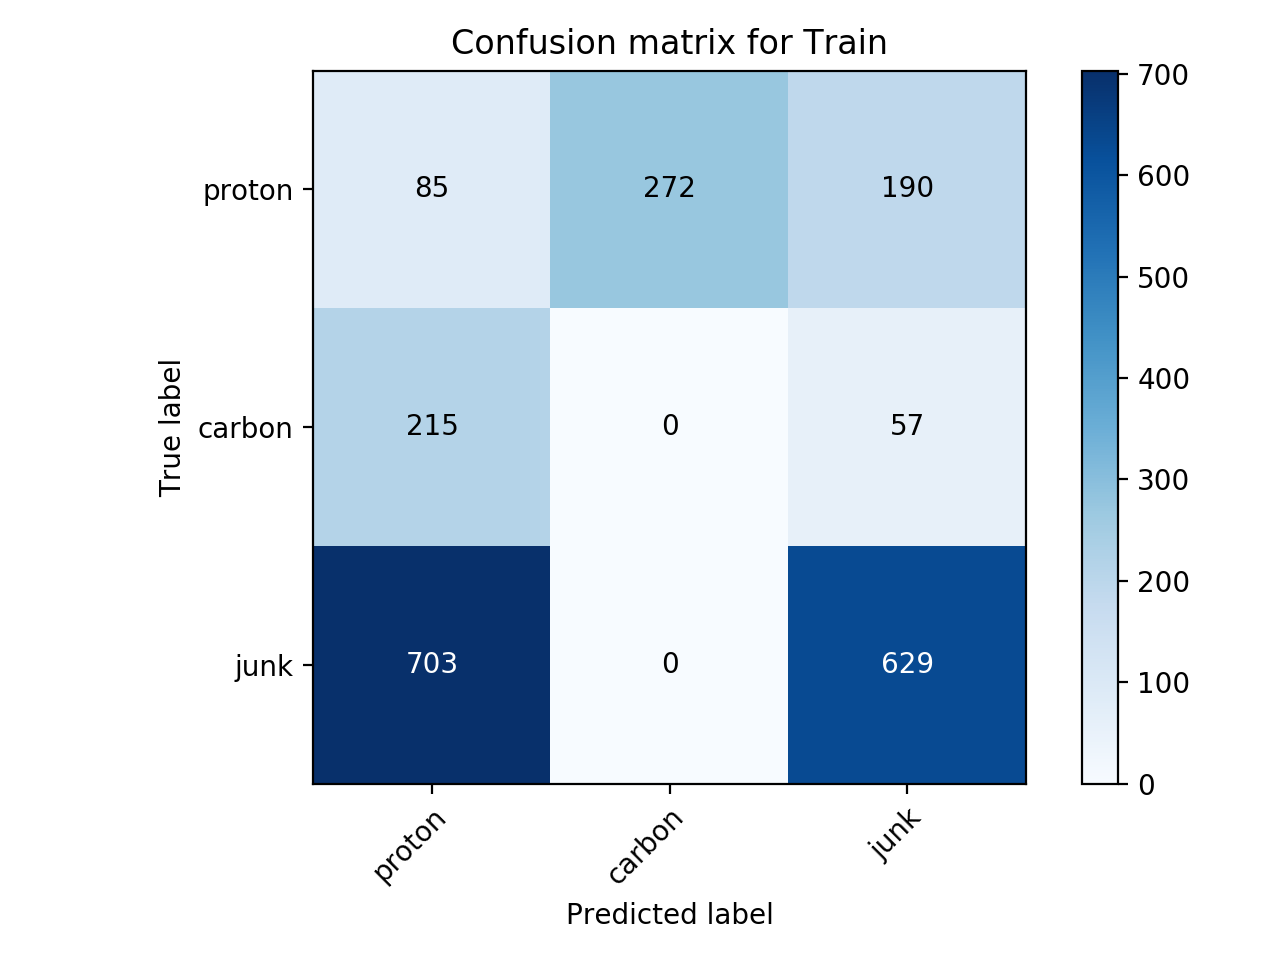

Scores on Train: 
ARI :  0.17425686476137453
NMI :  0.24849223119864153


/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [97]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix


a = plot_confusion_matrix(train_targets, train_pred, ["proton", "carbon", "junk"])
a.set_title("Confusion matrix for Train")

print("Scores on Train: ")
print("ARI : ", adjusted_rand_score(train_targets, train_pred))
print("NMI : ", normalized_mutual_info_score(train_targets, train_pred))


Confusion matrix, without normalization
[[ 16  37  63]
 [ 56  12   0]
 [199 155   0]]
Scores on Train: 
ARI :  0.18551008675248667
NMI :  0.26828985004976386


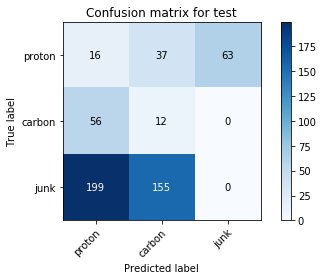

In [46]:
a = plot_confusion_matrix(test_targets, test_pred, ["proton", "carbon", "junk"])
a.set_title("Confusion matrix for test")


print("Scores on Train: ")
print("ARI : ", adjusted_rand_score(test_targets, test_pred))
print("NMI : ", normalized_mutual_info_score(test_targets, test_pred))


In [83]:
from sklearn.manifold import TSNE

projection = TSNE(2, perplexity=34, learning_rate=10).fit_transform(pca_vgg_train)


<IPython.core.display.Javascript object>


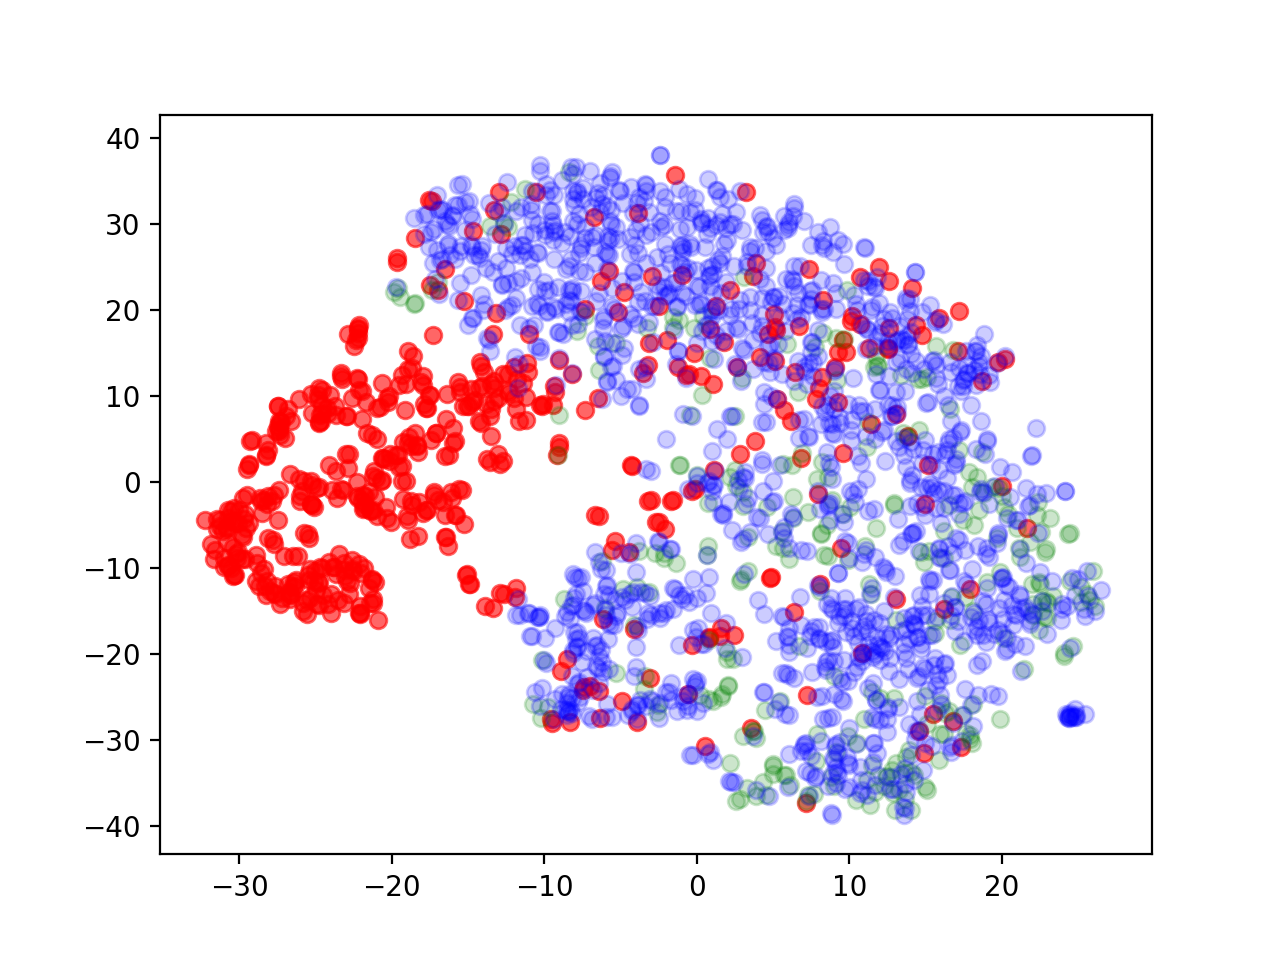

In [84]:
proton = projection[train_targets==0]
carbon = projection[train_targets==1]
junk = projection[train_targets==2]

fig, ax = plt.subplots()
ax.scatter(proton[:,0], proton[:,1], c="r", alpha=0.6)
ax.scatter(carbon[:,0], carbon[:,1], c="g", alpha=0.2)
ax.scatter(junk[:,0], junk[:,1], c="b", alpha=0.2)
plt.show()

<IPython.core.display.Javascript object>


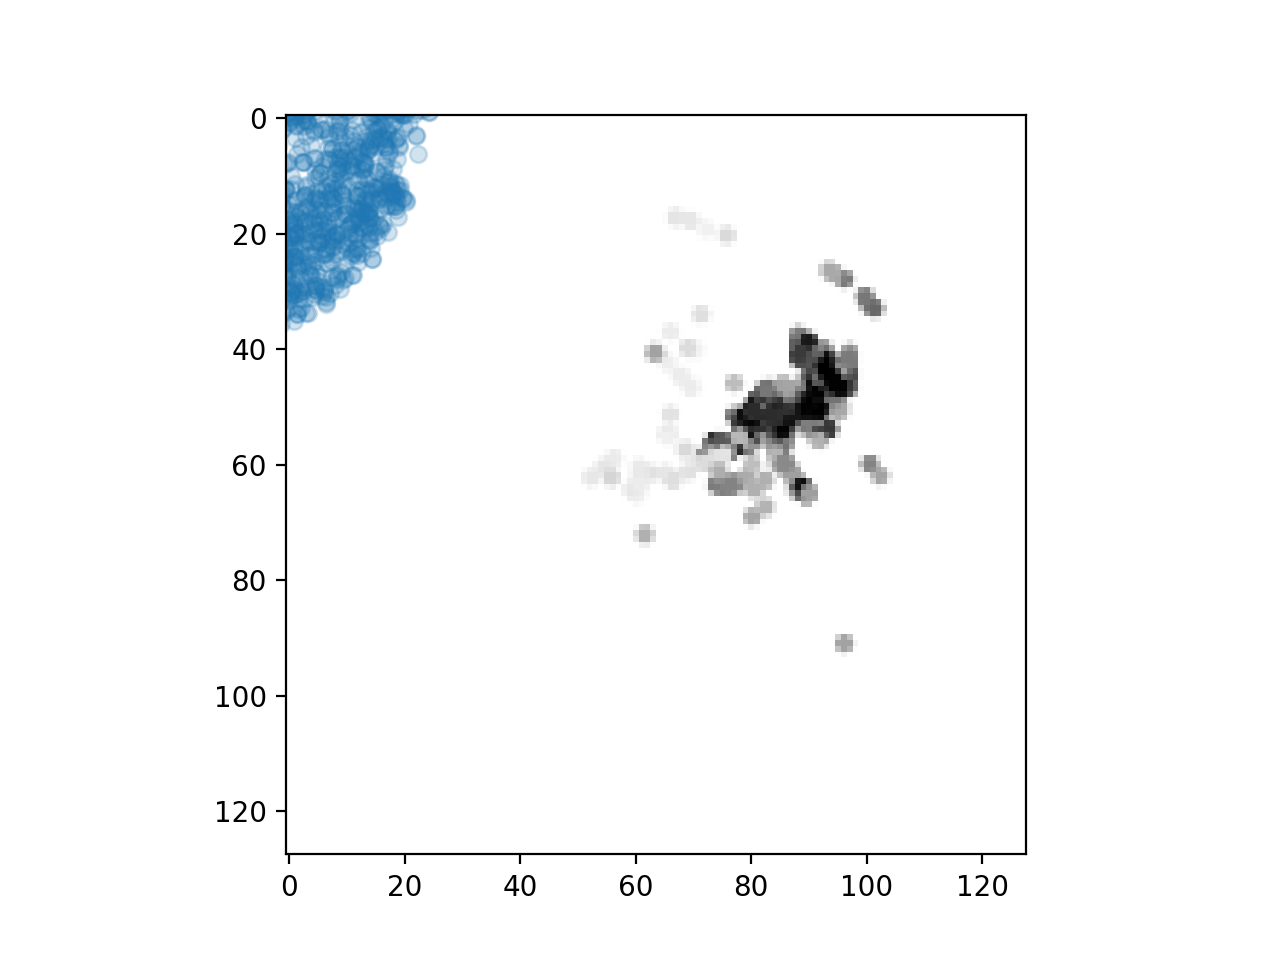

In [85]:
fig, ax = plt.subplots()
ax.scatter(projection[:,0], projection[:,1], alpha=0.2)
plt.show()